# Data Exploration - CLOB Risk Modelling

## Purpose

This notebook provides an initial exploration of market data to understand:
- Order book structure and liquidity depth
- Historical volatility patterns
- Trading volume characteristics
- Market microstructure (spreads, depth distribution)

## Data Sources

### Centralized Exchange (Binance)
- **Order Book**: Real-time bid/ask levels showing market depth
- **Historical Data**: OHLCV candles for volatility analysis
- **Volume Metrics**: 24-hour trading volumes and turnover

### Automated Market Maker (Uniswap)
- **Pool Liquidity**: Total value locked in AMM pools
- **Price Impact**: Slippage estimates for large trades
- **Volume**: Decentralized trading activity

In [1]:
# Setup
import sys
sys.path.append('../src')
from risk_model import notebook_helpers as nh, chart_config as cc
from risk_model import config, plotting, volume_analysis
import matplotlib.pyplot as plt

cc.setup_chart_style()
nh.setup_pandas_display()

# Load configuration for available markets
from risk_model.config import load_markets_config
markets_config = load_markets_config()

print("📊 CLOB Risk Model - Data Exploration")
print("=" * 50)
print(f"Markets configured: {len(markets_config['markets'])}")
print(f"Risk parameters loaded: ✓")
print(f"Data sources: Binance (spot & futures)\n")

In [2]:
# Load and display market configuration
markets_config = config.load_markets()
risk_params = config.get_risk_parameters()

print(f"Configured Markets ({len(markets_config['markets'])} total):")
for market in markets_config['markets']:
    print(f"  • {market['name']}: {market['category'].title()} tier, {market['oracle']} oracle")

Configured Markets (5 total):
  • ETH-PERP: Major tier, chainlink oracle
  • BTC-PERP: Major tier, chainlink oracle
  • SOL-PERP: Alt tier, pyth oracle
  • ARB-PERP: Alt tier, chainlink oracle
  • MATIC-PERP: Alt tier, chainlink oracle


## Data Collection

Fetching current market data for analysis. This includes:
- Order book snapshots (500 levels deep)
- 30 days of hourly price data
- Current spreads and volumes

In [3]:
# Fetch data for primary market (ETH)
primary_market = markets_config['markets'][0]
print(f"Analyzing {primary_market['name']}...")

market_data = nh.fetch_market_data([primary_market], lookback_days=30)

if market_data:
    data = list(market_data.values())[0]
    summary = nh.format_orderbook_summary(data['orderbook'])
    
    print(f"\nMarket Snapshot:")
    print(f"  • Price: ${data['current_price']:,.2f}")
    print(f"  • 24h Volume: ${data['volume_24h_usd']:,.0f}")
    print(f"  • Spread: {summary['spread_pct']:.3f}%")
    print(f"  • Bid/Ask Levels: {summary['bid_levels']}/{summary['ask_levels']}")

Analyzing ETH-PERP...



Market Snapshot:
  • Price: $3,116.39
  • 24h Volume: $10,058,640,939
  • Spread: 0.000%
  • Bid/Ask Levels: 500/500


## Order Book Analysis

### Liquidity Depth Visualization

The order book depth chart shows:
- **Cumulative liquidity** available at different price levels
- **Price impact** for trades of various sizes
- **Bid/ask asymmetry** indicating market sentiment

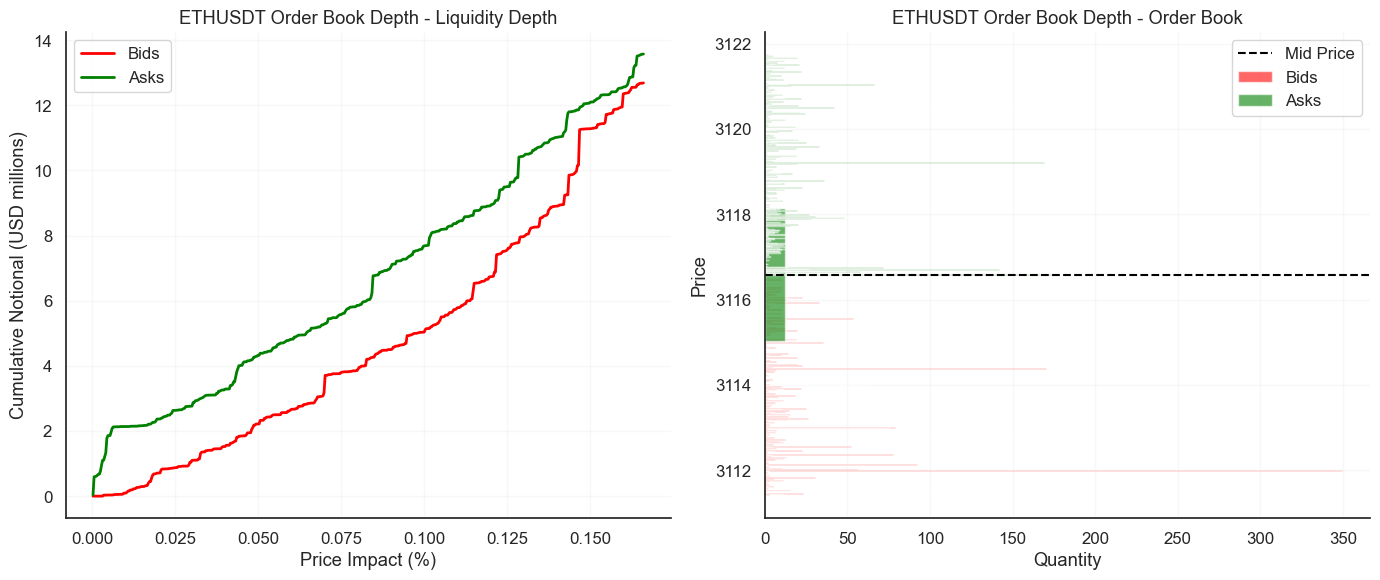


Liquidity at Various Impact Levels:
  • 0.1% impact: $6,360,466
  • 0.5% impact: $13,131,948
  • 1.0% impact: $13,131,948
  • 2.0% impact: $13,131,948


In [4]:
# Visualize order book depth
if market_data:
    fig, axes = plotting.plot_orderbook_depth(
        data['liquidity_curve'], 
        title=f"{data['symbol']} Order Book Depth"
    )
    plt.show()
    
    # Calculate key metrics
    impact_levels = [0.1, 0.5, 1.0, 2.0]
    print("\nLiquidity at Various Impact Levels:")
    for impact in impact_levels:
        depth = nh.pricing.depth_at_impact(data['liquidity_curve'], impact)
        print(f"  • {impact}% impact: ${depth:,.0f}")

## Volatility Analysis

### Historical Volatility Patterns

Volatility is a key risk factor that determines:
- Required margin levels
- Position limit adjustments
- Liquidation probability

We analyze volatility over multiple time horizons to capture both short-term market stress and long-term trends.

Realized Volatility (Annualized):
  •  1-day:  37.8%
  •  7-day:  69.1%
  • 30-day:  74.6%


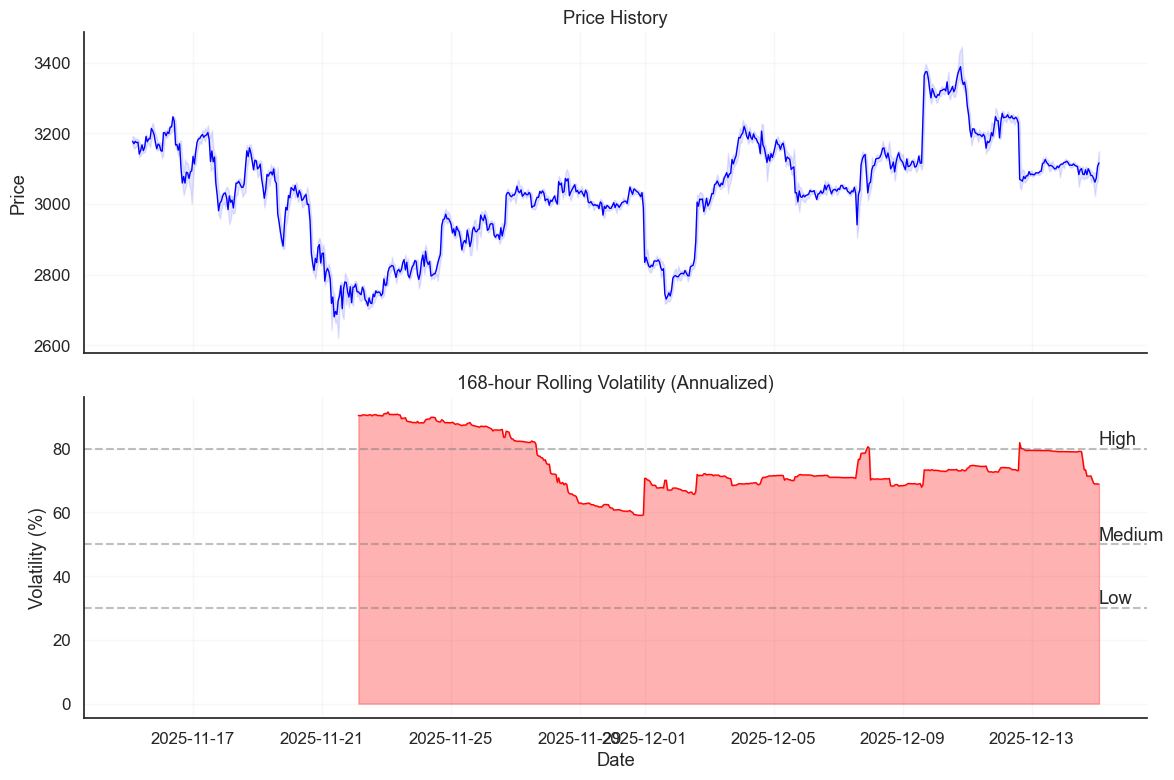

In [5]:
# Volatility analysis
if market_data:
    klines = data['klines']
    
    # Calculate volatility metrics
    vol_windows = [1, 7, 30]
    print("Realized Volatility (Annualized):")
    for window in vol_windows:
        vol = nh.pricing.realized_vol(klines, window=window*24) * 100
        print(f"  • {window:2d}-day: {vol:5.1f}%")
    
    # Volatility visualization
    fig, axes = plotting.plot_volatility_history(klines, window=24*7)
    plt.show()

## Volume Profile Analysis

### Trading Activity Patterns

Understanding volume patterns helps:
- Assess market liquidity health
- Identify optimal trading windows
- Calibrate OI/volume ratios

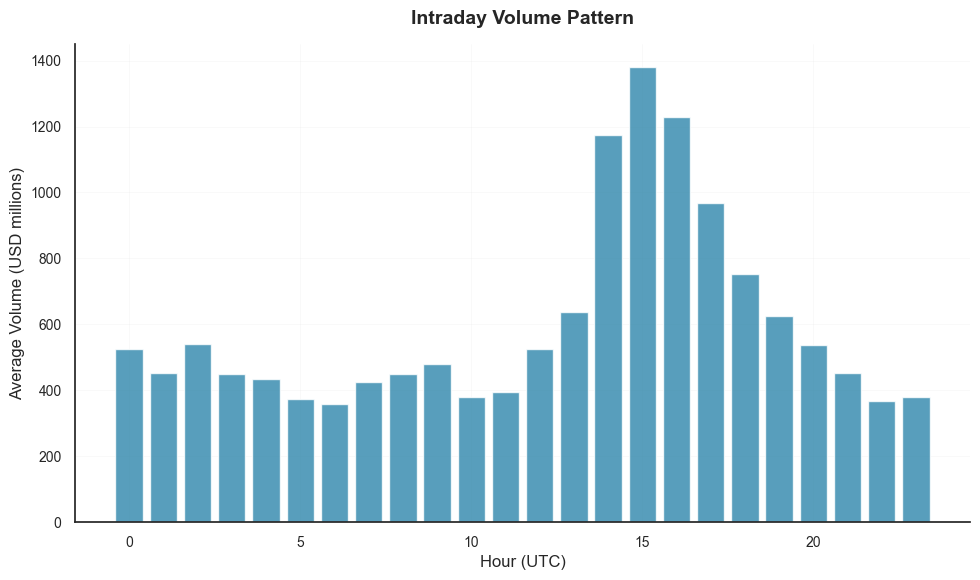

Peak Trading Hour: 15:00 UTC
Volume Concentration: Top 4 hours = 33.2%


In [6]:
# Volume analysis
if market_data:
    vol_analysis = data['volume_analysis']
    
    # Hourly volume patterns
    hourly_avg = vol_analysis.groupby('hour')['volume'].mean()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(hourly_avg.index, hourly_avg/1e6, color=cc.COLORS['primary'], alpha=0.8)
    cc.format_axis_labels(ax, 
                         xlabel='Hour (UTC)', 
                         ylabel='Average Volume (USD millions)',
                         title='Intraday Volume Pattern')
    plt.tight_layout()
    plt.show()
    
    print(f"Peak Trading Hour: {hourly_avg.idxmax()}:00 UTC")
    print(f"Volume Concentration: Top 4 hours = {hourly_avg.nlargest(4).sum()/hourly_avg.sum()*100:.1f}%")

## Market Comparison

### Cross-Market Analysis

Comparing multiple markets helps identify:
- Relative liquidity differences
- Volatility clustering
- Risk concentration

In [7]:
# Fetch data for multiple markets
print("Fetching data for market comparison...")
all_markets_data = nh.fetch_market_data(markets_config['markets'][:3], lookback_days=7)

# Create comparison table
comparison_df = nh.get_market_summary(all_markets_data)
comparison_df.style.format({
    'Price': '${:,.2f}',
    '24h Volume': '${:,.0f}',
    'Liquidity @ 1%': '${:,.0f}',
    'Volatility (%)': '{:.1f}%',
    'Spread (bps)': '{:.1f}'
})

Fetching data for market comparison...


Insufficient data: 168 < 720


Insufficient data: 168 < 720


Insufficient data: 168 < 720


,Market,Price,24h Volume,Liquidity @ 1%,Volatility (%),Spread (bps)
0,ETH-PERP,"$3,116.77","$10,058,662,617","$12,380,920",69.1%,0.0
1,BTC-PERP,"$89,263.60","$9,795,907,560","$9,726,666",42.8%,0.0
2,SOL-PERP,$131.72,"$2,087,049,747","$24,477,057",73.7%,0.8


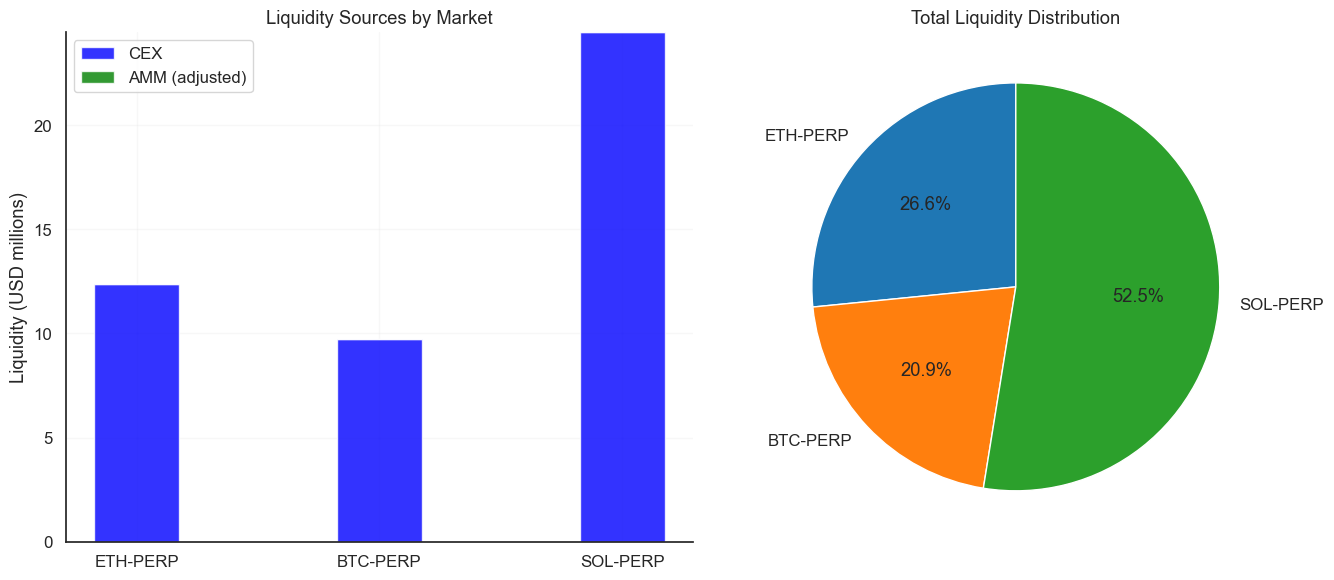

In [8]:
# Visualize liquidity comparison
if len(all_markets_data) > 1:
    fig, axes = plotting.plot_liquidity_comparison(all_markets_data)
    plt.show()

## Key Findings

### Liquidity Assessment

Based on the order book analysis:
- **Deep markets** (ETH, BTC) can absorb large trades with minimal impact
- **Shallow markets** require more conservative position limits
- **Asymmetric books** may indicate directional bias

### Volatility Insights

- **Current regime**: Compare recent volatility to historical averages
- **Volatility clustering**: Periods of high vol tend to persist
- **Risk scaling**: Higher volatility requires proportionally lower limits

### Volume Patterns

- **Peak hours**: Concentrated around major market opens
- **Weekend effects**: Generally lower volumes and wider spreads
- **OI considerations**: Volume supports position turnover

## Next Steps

With this foundational understanding of market structure:

1. **Risk Scoring**: Apply quantitative metrics to calculate risk scores
2. **Position Limits**: Determine appropriate OI and position limits
3. **Stress Testing**: Evaluate resilience under adverse scenarios

See the `risk_summary.ipynb` notebook for comprehensive risk analysis and limit recommendations.

## Technical Appendix

### Calculation Methodologies

**Realized Volatility**
- Log returns: $r_t = \ln(P_t / P_{t-1})$
- Volatility: $\sigma = \sqrt{\frac{252}{n} \sum r_t^2}$ (annualized)

**Liquidity Depth**
- Cumulative volume at each price level
- Price impact: percentage move from mid-price

**Spread Metrics**
- Absolute: $S = P_{ask} - P_{bid}$
- Relative: $S_{bps} = \frac{S}{P_{mid}} \times 10000$